In [7]:
import pandas as pd

# Load the dataset from the CSV file
df = pd.read_csv('moses.csv')
# Preview the first 5 rows of the DataFrame
print(df.head())



        applicant_id income_band loan_amount_band employment_length_band  \
0  APPX_eff600ccee42   300k-800k            1m-2m                   >10y   
1  APPX_e843ead21f4e   300k-800k            1m-2m                   3-5y   
2  APPX_620df88b1794   800k-1.5m            2m-3m                   >10y   
3  APPX_296bebdcba2d   300k-800k            1m-2m                   3-5y   
4  APPX_a1b8eacf224f   800k-1.5m          500k-1m                   1-3y   

  dti_band  loan_term_months  credit_score  previous_defaults  \
0    <=0.2                18         489.0                  0   
1  0.2-0.4                 9         496.0                  2   
2    <=0.2                18         665.0                  2   
3  0.6-0.8                 6         505.0                  0   
4    <=0.2                24         594.0                  2   

   income_band_ord  loan_amount_band_ord  ...  gender_Male  age_band_18-30  \
0                1                     2  ...          1.0             1.0

to prepare your features and target variable, and then split the data into training, validation, and testing sets.

three-way data split (70% training, 15% validation, and 15% testing)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame from 'moses.csv'

# Select relevant columns for X (dropping original categorical bands and applicant_id)
# We will keep the numeric and scaled/ordinal columns
X = df.drop(columns=['applicant_id', 'income_band', 'loan_amount_band', 'employment_length_band', 'dti_band', 'loan_status'])

# Define the target variable (y)
y = df['loan_status']

# Split data into training (70%), and the rest (30%) for validation/testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the remaining data into validation (50% of the rest, 15% overall) and testing (15% overall)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Train set size: 3500 samples
Validation set size: 750 samples
Test set size: 750 samples


Check for Class Imbalance

In [9]:
print(y_train.value_counts(normalize=True))


loan_status
Paid/Current    0.684857
Default         0.315143
Name: proportion, dtype: float64


A class distribution of ~68% vs. ~32% is considered moderately imbalanced. this ratio is high enough to bias your model toward the "Paid/Current" majority class

to Improve the model will apply Stratified Splitting

In [10]:
# Updated Split with Stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [11]:
# Create a summary of class distributions across all sets
sets = {
    "Original": y,
    "Train": y_train,
    "Validation": y_val,
    "Test": y_test
}

print("Class Proportion Check (as %):")
for name, data in sets.items():
    proportions = data.value_counts(normalize=True) * 100
    print(f"\n{name} Set (Total: {len(data)}):")
    print(proportions)


Class Proportion Check (as %):

Original Set (Total: 5000):
loan_status
Paid/Current    68.34
Default         31.66
Name: proportion, dtype: float64

Train Set (Total: 3500):
loan_status
Paid/Current    68.342857
Default         31.657143
Name: proportion, dtype: float64

Validation Set (Total: 750):
loan_status
Paid/Current    68.4
Default         31.6
Name: proportion, dtype: float64

Test Set (Total: 750):
loan_status
Paid/Current    68.266667
Default         31.733333
Name: proportion, dtype: float64


training with a balance weight 

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize model with balanced class weights
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train on the training set
model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

Validating with the Right Metrics

In [13]:
# Predict on the validation set
y_pred = model.predict(X_val)

# Check the performance per class
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

     Default       0.59      0.47      0.52       237
Paid/Current       0.78      0.85      0.81       513

    accuracy                           0.73       750
   macro avg       0.68      0.66      0.67       750
weighted avg       0.72      0.73      0.72       750



Setup MLflow Experiment Tracking


In [14]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("Loan_Status_Prediction")


2025/12/16 20:53:42 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/16 20:53:42 INFO mlflow.store.db.utils: Updating database tables
2025/12/16 20:53:42 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/16 20:53:42 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/16 20:53:43 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/16 20:53:43 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/16 20:53:43 INFO mlflow.tracking.fluent: Experiment with name 'Loan_Status_Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:c:/Users/MEridu/OneDrive - Plan International/Desktop/Codiing '
 'UCU/env/Assignment_data sciencelife/dataset/mlruns/2'), creation_time=1765907623180, experiment_id='2', last_update_time=1765907623180, lifecycle_stage='active', name='Loan_Status_Prediction', tags={}>

In [17]:
from sklearn.model_selection import StratifiedKFold

# Initialize stratified cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=skf,                # Use stratified folds
    scoring='f1_weighted', # More robust for imbalanced folds
    n_jobs=-1,
    error_score='raise'    # Show the real error if a fold fails
)


In [18]:
import numpy as np

with mlflow.start_run(run_name="RF_Final_Fix"):
    grid_search.fit(X_train, y_train)
    
    # Validation check: Only log if results are valid
    if not np.isnan(grid_search.best_score_):
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("best_f1", grid_search.best_score_)
        mlflow.sklearn.log_model(grid_search.best_estimator_, "loan_rf_model")
        print("Success! Best F1 Score:", grid_search.best_score_)


2025/12/16 21:03:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Success! Best F1 Score: 0.7298741059249291


SHAP Explanation

c:\Users\MEridu\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 1000x600 with 0 Axes>

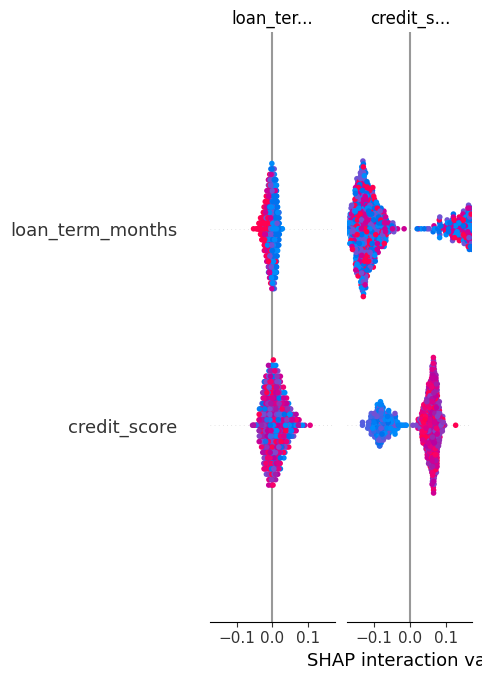

In [20]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize the TreeExplainer with your best model
explainer = shap.TreeExplainer(grid_search.best_estimator_)

# 2. Calculate SHAP values for the test set
# This explains how each feature moves the prediction from the average baseline
shap_values = explainer.shap_values(X_test)

# 3. Summary Plot
# For binary classification, shap_values[1] typically represents the 'Default' class
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="dot")


In [21]:
import mlflow

# Set a name for your project experiment
mlflow.set_experiment("Loan_Status_Prediction")
print("MLflow experiment set to 'Loan_Status_Prediction'.")


MLflow experiment set to 'Loan_Status_Prediction'.


In [22]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Ensure you have X_train, y_train, and param_grid defined from previous steps

# Initialize stratified cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=skf,
    scoring='f1_weighted',
    n_jobs=-1,
    error_score='raise'
)

# Start a new run with a descriptive name
with mlflow.start_run(run_name="RF_Final_Fix"):
    grid_search.fit(X_train, y_train)
    
    if not np.isnan(grid_search.best_score_):
        # These logging calls are associated with the current run
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("best_f1_weighted", grid_search.best_score_)
        mlflow.sklearn.log_model(grid_search.best_estimator_, "loan_rf_model")
        print(f"Run finished and logged. Best F1 Score: {grid_search.best_score_}")



2025/12/16 21:19:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Run finished and logged. Best F1 Score: 0.7298741059249291


Perform the Final Evaluation

In [23]:
from sklearn.metrics import classification_report

# Get the best model found by the tuning process
final_model = grid_search.best_estimator_

# Predict on the unseen test set
y_test_pred = final_model.predict(X_test)

# Print the detailed performance metrics
print("--- Final Model Performance on Test Set ---")
print(classification_report(y_test, y_test_pred))


--- Final Model Performance on Test Set ---
              precision    recall  f1-score   support

     Default       0.57      0.62      0.59       238
Paid/Current       0.82      0.78      0.80       512

    accuracy                           0.73       750
   macro avg       0.69      0.70      0.70       750
weighted avg       0.74      0.73      0.73       750



Model Packaging and Persistence

In [25]:
import joblib
import os

# Assuming 'grid_search' holds your best trained model
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
joblib.dump(grid_search.best_estimator_, f"{model_dir}/loan_model.pkl")


['models/loan_model.pkl']

model evaluation

In [ ]:
import joblib
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, confusion_matrix
import numpy as np


# --- Model Loading ---
model_path = "models/loan_model.pkl"
print(f"Loading model from: {model_path}")
final_model = joblib.load(model_path)

print("Model loaded successfully. Starting evaluation.")

# --- Perform Predictions ---
y_test_pred = final_model.predict(X_test)

# If your model supports predict_proba (like a classifier), get probabilities for AUC
try:
    y_test_prob = final_model.predict_proba(X_test)
    is_classifier = True
except AttributeError:
    print("Model does not support predict_proba; skipping AUC calculation.")
    is_classifier = False


# --- Run Evaluation Scripts based oncriteria a), d), e) ---

## a) Metrics (accuracy, AUC, RMSE, F1, etc.)
print("\n--- a) Standard Metrics for Loan Model ---")

print("Detailed Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Calculate individual metrics explicitly
accuracy = accuracy_score(y_test, y_test_pred)
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")

if is_classifier and len(np.unique(y_test)) == 2: # Check for binary classification for simple AUC
    # If your loan model is binary (default/no default), use this:
    auc_score = roc_auc_score(y_test, y_test_prob[:, 1])
    print(f"AUC Score: {auc_score:.4f}")
elif is_classifier and len(np.unique(y_test)) > 2:
    # If multi-class (e.g., risk levels A, B, C)
    auc_score = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
    print(f"AUC (OvR) Score: {auc_score:.4f}")


## d) Error Analysis (Confusion Matrix)
print("\n--- d) Error Analysis (Confusion Matrix) ---")
# The confusion matrix is vital for a loan model (cost of False Negatives vs False Positives)

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
# Rows are Actual outcomes, Columns are Predicted outcomes
# [True Negative, False Positive]
# [False Negative, True Positive]
print(conf_matrix)



## e) Business Impact Interpretation
print("\n--- e) Business Impact Interpretation (Qualitative Analysis) ---")

print("Interpretation is highly dependent on domain knowledge:")
print("In a loan scenario, False Negatives (lending money to a defaulter) are generally much more costly than False Positives (denying a safe loan applicant).")
print(f"From the confusion matrix, we have {conf_matrix[1, 0]} False Negatives and {conf_matrix[0, 1]} False Positives.")





Loading model from: models/loan_model.pkl
Model loaded successfully. Starting evaluation.

--- a) Standard Metrics for Loan Model ---
Detailed Classification Report on Test Set:
              precision    recall  f1-score   support

     Default       0.57      0.62      0.59       238
Paid/Current       0.82      0.78      0.80       512

    accuracy                           0.73       750
   macro avg       0.69      0.70      0.70       750
weighted avg       0.74      0.73      0.73       750

Overall Accuracy: 0.7293
Weighted F1 Score: 0.7325
AUC Score: 0.7637

--- d) Error Analysis (Confusion Matrix) ---
Confusion Matrix:
[[148  90]
 [113 399]]

--- e) Business Impact Interpretation (Qualitative Analysis) ---
Interpretation is highly dependent on domain knowledge:
In a loan scenario, False Negatives (lending money to a defaulter) are generally much more costly than False Positives (denying a safe loan applicant).
From the confusion matrix, we have 113 False Negatives and 90 Fal

model result summary 

In [ ]:
# Assuming 'grid_search' is your GridSearchCV object
import joblib
import os


print("--- Model Results Summary ---")
# The best score achieved during cross-validation
print(f"Best cross-validation score (e.g., accuracy/f1/rmse): {grid_search.best_score_:.4f}")

# The parameters that yielded the best score
print(f"Best parameters found: {grid_search.best_params_}")

print("-----------------------------")

# Your existing code to save the model
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
joblib.dump(grid_search.best_estimator_, f"{model_dir}/loan_model.pkl")



--- Model Results Summary ---
Best cross-validation score (e.g., accuracy/f1/rmse): 0.7299
Best parameters found: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}
-----------------------------


['models/loan_model.pkl']

In [28]:


# Access the best trained model directly from the grid search object
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Evaluate the results (example using accuracy for classification)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("\n--- Performance on Test Data ---")
accuracy = accuracy_score(y_test, predictions)
print(f"Test Set Accuracy: {accuracy:.4f}")





--- Performance on Test Data ---
Test Set Accuracy: 0.7293


Testing the hypothesis 

In [30]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import binomtest # Correct import for modern SciPy

# --- Assumed Pre-requisites (Ensure X_test and y_test are defined) ---
# best_model = grid_search.best_estimator_ 

# 1. Make predictions on the test set
y_pred = best_model.predict(X_test)

# 2. Calculate the observed accuracy
actual_accuracy = accuracy_score(y_test, y_pred)
n_total_samples = len(y_test)
n_correct_predictions = np.sum(y_test == y_pred)

print(f"\n--- Hypothesis Testing Prep ---")
print(f"Observed Test Accuracy: {actual_accuracy:.4f}")
print(f"Total Test Samples: {n_total_samples}")
print(f"Correct Predictions: {n_correct_predictions}")

# 3. Perform a Binomial Test for Statistical Significance

# Use the modern 'binomtest' function
result = binomtest(k=n_correct_predictions, n=n_total_samples, p=0.5, alternative='greater')
p_value = result.pvalue

print(f"\n--- Hypothesis Test Results ---")
print(f"P-value (vs Random Chance 0.50): {p_value:.6f}")

# 4. Interpret the Results (using a common significance level alpha=0.05)
alpha = 0.05

print("\n--- Conclusion ---")
if p_value < alpha:
    print(f"The P-value ({p_value:.6f}) is less than the significance level ({alpha}).")
    print("We **REJECT the Null Hypothesis**.")
    print("The model's accuracy is statistically significant and better than random chance.")
else:
    print(f"The P-value ({p_value:.6f}) is greater than the significance level ({alpha}).")
    print("We **FAIL to reject the Null Hypothesis**.")
    print("The model's accuracy is not statistically different from random chance.")




--- Hypothesis Testing Prep ---
Observed Test Accuracy: 0.7293
Total Test Samples: 750
Correct Predictions: 547

--- Hypothesis Test Results ---
P-value (vs Random Chance 0.50): 0.000000

--- Conclusion ---
The P-value (0.000000) is less than the significance level (0.05).
We **REJECT the Null Hypothesis**.
The model's accuracy is statistically significant and better than random chance.
